# Shape classification from 3D point clouds
* point transformer
* S3DIS dataset: 12 segments + 1 clutter
    * ceiling, floor, wall, beam, column, window, door, table, chair, sofa, bookcase, board
* task: inductive node classification
* Use ShapeNet: https://shapenet.org/
* unofficial: https://github.com/POSTECH-CVLab/point-transformer
* official: https://github.com/qq456cvb/Point-Transformers/blob/master/models/Hengshuang/transformer.py
* cuda error message: https://stackoverflow.com/questions/43022843/nvidia-nvml-driver-library-version-mismatch
  
`sudo rmmod nvidia_uvm`


`sudo modprobe nvidia_uvm`

## Import libraries

In [1]:
import torch
from torch_geometric.datasets import ShapeNet
from torch_geometric import transforms
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.nn import Sequential, Linear, ReLU, Module
from torch_geometric.nn import ( 
    PointTransformerConv, 
    MLP, 
    fps, 
    global_mean_pool, 
    knn,
    knn_graph,
)
from torch_geometric.utils import scatter
from torch.nn import functional as F
from torch_geometric.typing import WITH_TORCH_CLUSTER

if not WITH_TORCH_CLUSTER:
    quit("This example requires 'torch-cluster'")
    
%matplotlib inline

## Set up variables

In [2]:
data_path = '../data/ShapeNet'

CATEGORY_ID_TO_NAME = {
    0: 'Airplane',
    1: 'Bag',
    2: 'Cap',
    3: 'Car',
    4: 'Chair',
    5: 'Earphone',
    6: 'Guitar',
    7: 'Knife',
    8: 'Lamp',
    9: 'Laptop',
    10: 'Motorbike',
    11: 'Mug',
    12: 'Pistol',
    13: 'Rocket',
    14: 'Skateboard',
    15: 'Table',
}

## Helper functions

In [3]:
def count_example_by_class(dataset) -> dict:
    """Count examples by class"""
    counter_dict = defaultdict(int)
    for data in dataset:
        category_id = data['category'].item() # tolist()[0]
        category_name = CATEGORY_ID_TO_NAME[category_id]        
        counter_dict[(category_name, category_id)] += 1
    return counter_dict

def calc_class_weight(datasets_train, counter_train) -> (list, torch.tensor):
    """Calculate class weight from training dataset"""
    # calculate class weight: heavier weight for smaller class size
    num_sample = datasets_train.len()
    num_class = len(counter_train)
    samples_per_class = [0] * num_class
    for key, count in counter_train.items():
        class_name, class_id = key
        samples_per_class[class_id] = count
    # print(samples_per_class)    
    class_weight = []
    for class_id in range(num_class):
        class_weight.append(num_sample / (samples_per_class[class_id] * num_class))
    class_weight_tensor = torch.tensor(class_weight)
    # print(class_weight_tensor)
    return samples_per_class, class_weight_tensor

def visualize_points(pos, edge_index=None, index=None, colors=None, elev=10, azim=-20, roll=0):
    fig = plt.figure(figsize=(4, 4))
    # fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection='3d')
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
            src = pos[src].tolist()
            dst = pos[dst].tolist()
             # plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
            ax.plot(
                [src[0], dst[0]], [src[1], dst[1]], [src[2], dst[2]], 
                linewidth=0.5, color='black', alpha=0.2
            )
    if index is None:
        if colors:
            sc = ax.scatter(
                pos[:, 0], pos[:, 1], pos[:, 2], s=5, zorder=1000, c=colors, cmap='tab20', 
                vmax=12, vmin=0, alpha=0.2,
            )
        else:
            sc = ax.scatter(
                pos[:, 0], pos[:, 1], pos[:, 2], s=5, zorder=1000, c='k', alpha=0.2
            )
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    # plt.axis('off')
    ax.view_init(elev=elev, azim=azim, roll=roll)
    # ax.set_xlabel('X')
    # ax.set_ylabel('Y')
    # ax.set_zlabel('Z')
    ax.set_axis_off()
    if colors:
        fig.colorbar(sc, shrink=0.5, aspect=20)
    plt.show()    

def transform_dataset(dataset, k=6):
    # # copy category into y as working on 3D object classification
    # for idx in range(len(dataset)):
    #     dataset[idx]['y'] = dataset[idx]['category'].detach().clone()
    dataset.transform = transforms.KNNGraph(k=6)
    
    return dataset



## Download dataset

In [4]:
datasets_train = ShapeNet(root=data_path, categories=None, split='train')   
datasets_val = ShapeNet(root=data_path, categories=None, split='val')
# dataset = ShapeNet(root='/tmp/ShapeNet', categories=['Airplane'],
#                     pre_transform=T.KNNGraph(k=6))

## Explore data
* 0: Airplane, 1: Bag, 2: Cap, 3: Car, 4: Chair, 
* 5: Earphone, 6: Guitar, 7: Knife, 8: Lamp, 9: 'Laptop' ,
* 10: 'Motorbike', 11: 'Mug', 12: 'Pistol', 13: 'Rocket', 14: 'Skateboard', 
* 15: 'Table'

In [5]:
!ls {data_path}
# dataset size
print(f'dataset size: {len(datasets_train)}')
data_train = datasets_train[0]
print(data_train)

processed  raw
dataset size: 12137
Data(x=[2252, 3], y=[2252], pos=[2252, 3], category=[1])


In [6]:
print(datasets_train.get_summary())
print(datasets_train.categories)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12137/12137 [00:00<00:00, 13099.90it/s]

ShapeNet (#graphs=12137):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |   2613.4 |        0 |
| std        |    283.6 |        0 |
| min        |    537   |        0 |
| quantile25 |   2568   |        0 |
| median     |   2694   |        0 |
| quantile75 |   2762   |        0 |
| max        |   2974   |        0 |
+------------+----------+----------+
['Airplane', 'Bag', 'Cap', 'Car', 'Chair', 'Earphone', 'Guitar', 'Knife', 'Lamp', 'Laptop', 'Motorbike', 'Mug', 'Pistol', 'Rocket', 'Skateboard', 'Table']


In [7]:
# calculate class size
counter_train = count_example_by_class(datasets_train)
counter_val = count_example_by_class(datasets_val)
display(counter_train)
display(counter_val)

defaultdict(int,
            {('Knife', 7): 277,
             ('Airplane', 0): 1958,
             ('Laptop', 9): 324,
             ('Table', 15): 3835,
             ('Chair', 4): 2658,
             ('Lamp', 8): 1118,
             ('Guitar', 6): 550,
             ('Earphone', 5): 49,
             ('Rocket', 13): 46,
             ('Mug', 11): 130,
             ('Car', 3): 659,
             ('Pistol', 12): 209,
             ('Bag', 1): 54,
             ('Motorbike', 10): 125,
             ('Cap', 2): 39,
             ('Skateboard', 14): 106})

defaultdict(int,
            {('Airplane', 0): 391,
             ('Chair', 4): 396,
             ('Table', 15): 588,
             ('Car', 3): 81,
             ('Lamp', 8): 143,
             ('Mug', 11): 16,
             ('Laptop', 9): 44,
             ('Guitar', 6): 78,
             ('Skateboard', 14): 15,
             ('Motorbike', 10): 26,
             ('Pistol', 12): 30,
             ('Bag', 1): 8,
             ('Knife', 7): 35,
             ('Cap', 2): 5,
             ('Earphone', 5): 6,
             ('Rocket', 13): 8})

In [8]:
# calculate class weight
samples_per_class, class_weight_tensor = calc_class_weight(datasets_train, counter_train)
print(class_weight_tensor)

samples_per_class_val, _ = calc_class_weight(datasets_val, counter_val)

tensor([ 0.3874, 14.0475, 19.4503,  1.1511,  0.2854, 15.4809,  1.3792,  2.7385,
         0.6785,  2.3412,  6.0685,  5.8351,  3.6295, 16.4905,  7.1562,  0.1978])


Knife


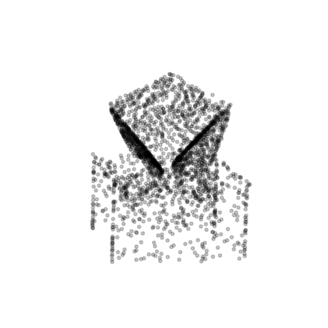

Airplane


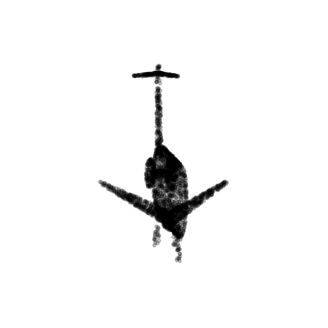

Laptop


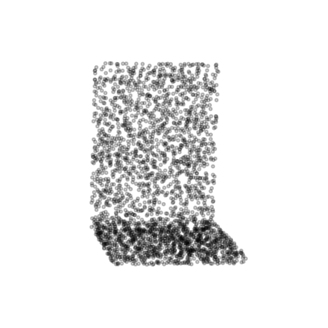

Table


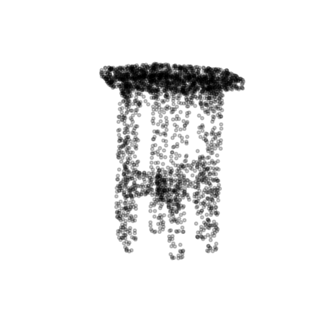

Chair


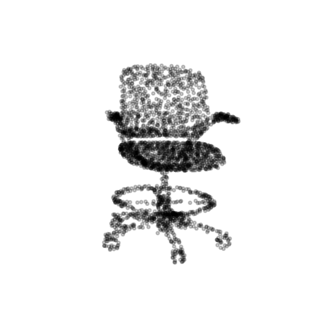

In [9]:
# explore
for idx in range(5):
    data = datasets_train[idx]
    print(CATEGORY_ID_TO_NAME[data['category'].tolist()[0]])
    # visualize_points(pos=data.pos, elev=-20, azim=45, roll=45)
    visualize_points(pos=data.pos, elev=10, azim=10, roll=90)

## Transform data
* Working on object classification, not part segmentation, label should be category

In [10]:
datasets_train = transform_dataset(datasets_train, k=6)
datasets_val = transform_dataset(datasets_val, k=6)

In [11]:
datasets_train[0]

Data(x=[2252, 3], y=[2252], pos=[2252, 3], category=[1], edge_index=[2, 13512])

Knife


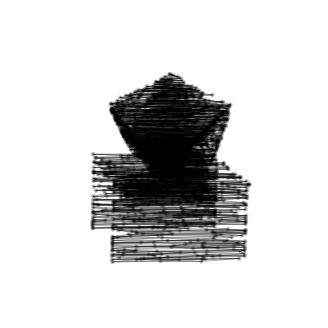

Airplane


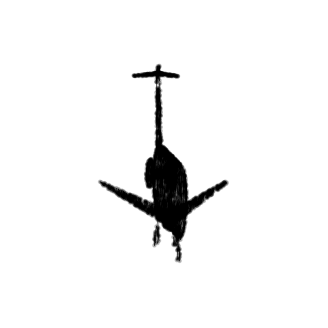

Laptop


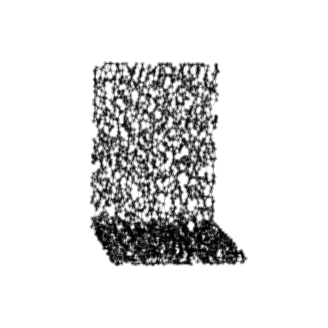

Table


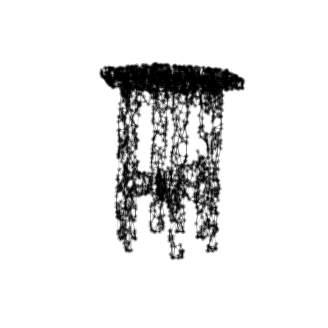

Chair


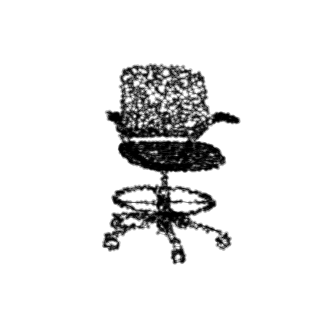

In [12]:
# explore
for idx in range(5):
    data = datasets_train[idx]
    print(CATEGORY_ID_TO_NAME[data['category'].tolist()[0]])
    # visualize_points(pos=data.pos, elev=-20, azim=45, roll=45)
    visualize_points(pos=data.pos, elev=10, azim=10, roll=90, edge_index=data.edge_index)

## Data Loader

In [13]:
train_loader = DataLoader(datasets_train, batch_size=32, shuffle=True)
val_loader = DataLoader(datasets_val, batch_size=32, shuffle=False)

## Build model
* MLP, Point Transformer block, Transition Down, Global Avg Pooling
* https://github.com/pyg-team/pytorch_geometric/blob/master/examples/point_transformer_classification.py

In [14]:
# each block
class TransformerBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # The same number of input and out neurons for linear layer
        self.lin_in = Linear(in_channels, in_channels)
        self.lin_out = Linear(out_channels, out_channels)
        # 3: position in 3D, 64: hidden layer: hyperparameters, 
        # no normalization, nonlinearity to the last layer
        self.pos_nn = MLP([3, 64, out_channels], norm=None, plain_last=False)
        self.attn_nn = MLP([out_channels, 64, out_channels], norm=None,
                           plain_last=False)
        self.transformer = PointTransformerConv(
            in_channels=in_channels, out_channels=out_channels, 
            pos_nn=self.pos_nn, attn_nn=self.attn_nn, 
        )

    def forward(self, x, pos, edge_index):
        # x = self.lin_in(x)
        # x = ReLU(x)
        x - self.lin_in(x).relu()
        x = self.transformer(x, pos, edge_index)
        x = self.lin_out(x).relu()
        # x = self.lin_out(x)
        # x = ReLU(x)
        return x


class TransitionDown(torch.nn.Module):
    """Samples the input point cloud by a ratio percentage to reduce
    cardinality and uses an mlp to augment features dimensionnality.
    """
    def __init__(self, in_channels, out_channels, ratio=0.25, k=16):
        """
        :param ratio: float, transition down ratio.
        :param k: int, pool feature vectors using kNN graph. Default: 16
        """
        super().__init__()
        self.ratio = ratio
        self.k = k
        # batch norm, ReLU, 
        self.mlp = MLP([in_channels, out_channels], plain_last=False)

    def forward(self, x, pos, batch):
        # fps (Farthest Point Sampling)
        id_clusters = fps(pos, batch=batch, ratio=self.ratio)  # x -> pos
        # knn 
        # compute for each cluster the k nearest points
        sub_batch = batch[id_clusters] if batch is not None else None
        
        # beware of self loop
        id_k_neighbor = knn(pos, pos[id_clusters], k=self.k, batch_x=batch,
                            batch_y=sub_batch)
        # MLP
        x = self.mlp(x)
        # local max pooling
        # Max pool onto each cluster the features from knn in points
        x_out = scatter(x[id_k_neighbor[1]], id_k_neighbor[0], dim=0,
                        dim_size=id_clusters.size(0), reduce='max')
        
        # keep only the clusters and their max-pooled features
        sub_pos, out = pos[id_clusters], x_out
        return out, sub_pos, sub_batch

In [15]:
# Point Transformer Network for classification
class PointTransformerNet(torch.nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, dim_model: list[int], 
        k: int = 16, ratio=0.25, seed=1234
    ):
        # what is dim_model?: out_channels?
        super().__init__()
        # for consistent result per seed
        torch.manual_seed(seed)
        self.k = k
        self.ratio = ratio

        # dummy feature is created if there is none given
        in_channels = max(in_channels, 1)
        
        # block 1: MLP and point transfmer (N, 32)
        self.mlp_in = MLP([in_channels, dim_model[0]], plain_last=False)
        self.point_transformer_in = TransformerBlock(in_channels=dim_model[0], out_channels=dim_model[0])  
        # backbone_layers: block 2~5 (N/4, 64), (N/16, 128), (N/64, 256), (N/256, 512)         
        self.transition_down = torch.nn.ModuleList()
        self.point_transformer_down = torch.nn.ModuleList()

        for idx in range(len(dim_model) - 1):
            # transition block then transformer block
            self.transition_down.append(
                TransitionDown(
                    in_channels=dim_model[idx], out_channels=dim_model[idx + 1], 
                    ratio=self.ratio, k=self.k
                )
            )
            self.point_transformer_down.append(
                TransformerBlock(in_channels=dim_model[idx + 1], out_channels=dim_model[idx + 1])
            )

        # # block 6: Global avg pooling, (1, 512)
        # self.global_avg_pooling_bl6 = global_mean_pool
        
        # block 7: MLP: Linear(N, dataset.num_classes) (1, Dout)
        self.mlp_out = MLP([dim_model[-1], 64, out_channels], norm=None)            

    def forward(self, x, pos, batch=None):
        # add dummy features in case there is none
        if x is None:
            x = torch.ones((pos.shape[0], 1), device=pos.get_device())

        # block 1
        x = self.mlp_in(x)
        # build graph again with new x
        edge_index = knn_graph(pos, k=self.k, batch=batch)
        x = self.point_transformer_in(x, pos, edge_index)

        # backbone
        for idx in range(len(self.point_transformer_down)):
            x, pos, batch = self.transition_down[idx](x, pos, batch)
            # new graph, pos
            edge_index = knn_graph(pos, k=self.k, batch=batch)
            x = self.point_transformer_down[idx](x, pos, edge_index)

        # global average pooling
        x = global_mean_pool(x, batch)

        # classification
        out = self.mlp_out(x)
        
        return F.log_softmax(out, dim=-1)
        

def train_model(model, loader, device, optimizer, total_num_example, label_name='y', class_weight_tensor=None):
    model.train()
    if class_weight_tensor is not None:
        class_weight_tensor = class_weight_tensor.to(device)
        
    total_loss = 0
    for data in loader:
        data = data.to(device)
        # reset gradient
        optimizer.zero_grad()
        out = model(data.x, data.pos, data.batch)
        if class_weight_tensor is None:
            loss = F.nll_loss(out, data[label_name])
        else:            
            loss = F.nll_loss(out, data[label_name], weight=class_weight_tensor)
            
        loss.backward()
        # calculate cost, single value from a tensor, unpack average to total
        total_loss += loss.item() * data.num_graphs
        # update gradient
        optimizer.step()
    
    return total_loss / total_num_example


@torch.no_grad()
def test_model(model, loader, device, label_name='y', num_class=None, samples_per_class=None):
    model.eval()
    # accuracy: should modify this
    correct = 0
    if num_class:
        correct_by_class = {class_id: 0 for class_id in range(num_class)}
    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.pos, data.batch).max(dim=1)[1]
        # overall accuracy
        correct += pred.eq(data[label_name]).sum().item()
        # mACC (mean accuracy within each category)
        if num_class:
            for class_id in range(num_class):
                # correponding mask
                class_mask = data[label_name] == class_id
                if class_mask.sum() > 0:
                    new_correct_class = pred[class_mask].eq(data[label_name][class_mask]).sum().item()
                    correct_by_class[class_id] += new_correct_class

    overall_accuracy = correct / len(loader.dataset)
    if num_class:        
        accuracy_by_class = 0
        for class_id, correct in correct_by_class.items():
            accuracy_by_class += correct / samples_per_class[class_id]
        # average
        accuracy_by_class /= num_class        
        
        return overall_accuracy, accuracy_by_class    
    else:
        return overall_accuracy


## Train model: 10 mins per 1 iteration

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

# in_channels: int, out_channels: int, dim_model: list[int], 
#         k: int = 16, ratio=0.25, seed=1234
num_class = len(samples_per_class)

model = PointTransformerNet(
    in_channels=datasets_train.num_features, out_channels=num_class, 
    # (N, 32),  (N/4, 64), (N/16, 128), (N/64, 256), (N/256, 512) 
    dim_model = [32, 64, 128, 256, 512], k=16, ratio=0.25, seed=1234  
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
# num_epochs = 1 # 200
num_epochs = 20 # 200

display(model)

cuda


PointTransformerNet(
  (mlp_in): MLP(3, 32)
  (point_transformer_in): TransformerBlock(
    (lin_in): Linear(in_features=32, out_features=32, bias=True)
    (lin_out): Linear(in_features=32, out_features=32, bias=True)
    (pos_nn): MLP(3, 64, 32)
    (attn_nn): MLP(32, 64, 32)
    (transformer): PointTransformerConv(32, 32)
  )
  (transition_down): ModuleList(
    (0): TransitionDown(
      (mlp): MLP(32, 64)
    )
    (1): TransitionDown(
      (mlp): MLP(64, 128)
    )
    (2): TransitionDown(
      (mlp): MLP(128, 256)
    )
    (3): TransitionDown(
      (mlp): MLP(256, 512)
    )
  )
  (point_transformer_down): ModuleList(
    (0): TransformerBlock(
      (lin_in): Linear(in_features=64, out_features=64, bias=True)
      (lin_out): Linear(in_features=64, out_features=64, bias=True)
      (pos_nn): MLP(3, 64, 64)
      (attn_nn): MLP(64, 64, 64)
      (transformer): PointTransformerConv(64, 64)
    )
    (1): TransformerBlock(
      (lin_in): Linear(in_features=128, out_features=1

In [17]:
%%time
for epoch in range(1, num_epochs + 1):
    # model, loader, device, optimizer, total_example, class_weight_tensor=None
    loss = train_model(
        model=model, loader=train_loader, device=device, optimizer=optimizer, 
        total_num_example=len(datasets_train), label_name='category',
        class_weight_tensor=class_weight_tensor
    )  
    # test_model(model, loader, device, num_class=None, samples_per_class=None):
    overall_acc_val, accuracy_by_class = test_model(
        model=model, loader=val_loader, device=device, label_name='category', 
        num_class=num_class, samples_per_class=samples_per_class_val
    )
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val_oAcc: {overall_acc_val:.4f}, Val_mAcc: {accuracy_by_class:.4f}')
    scheduler.step()

Epoch 001, Loss: 1.5950, Val_oAcc: 0.2834, Val_mAcc: 0.3298
Epoch 002, Loss: 1.0233, Val_oAcc: 0.8620, Val_mAcc: 0.7215
Epoch 003, Loss: 0.6850, Val_oAcc: 0.8193, Val_mAcc: 0.8209
Epoch 004, Loss: 0.6216, Val_oAcc: 0.8920, Val_mAcc: 0.8753
Epoch 005, Loss: 0.4315, Val_oAcc: 0.7053, Val_mAcc: 0.8180
Epoch 006, Loss: 0.3617, Val_oAcc: 0.9016, Val_mAcc: 0.8175
Epoch 007, Loss: 0.3121, Val_oAcc: 0.9257, Val_mAcc: 0.8661
Epoch 008, Loss: 0.2793, Val_oAcc: 0.9439, Val_mAcc: 0.9281
Epoch 009, Loss: 0.2324, Val_oAcc: 0.9599, Val_mAcc: 0.8954
Epoch 010, Loss: 0.2101, Val_oAcc: 0.9481, Val_mAcc: 0.9286
Epoch 011, Loss: 0.3264, Val_oAcc: 0.9652, Val_mAcc: 0.9201
Epoch 012, Loss: 0.1951, Val_oAcc: 0.9032, Val_mAcc: 0.9121
Epoch 013, Loss: 0.2397, Val_oAcc: 0.9610, Val_mAcc: 0.9113
Epoch 014, Loss: 0.1680, Val_oAcc: 0.9332, Val_mAcc: 0.9239
Epoch 015, Loss: 0.1569, Val_oAcc: 0.9717, Val_mAcc: 0.9107
Epoch 016, Loss: 0.1761, Val_oAcc: 0.9465, Val_mAcc: 0.8995
Epoch 017, Loss: 0.1836, Val_oAcc: 0.971

## Save model

In [18]:
# save model
model_path = '../models/shape_classification/point_transformer.pt'
torch.save(model.state_dict(), model_path)
#
!ls -lh {'../models/shape_classification'}

total 8.3M
-rw-rw-r-- 1 stephen stephen 8.3M Jan 24 09:54 point_transformer.pt
